In [ ]:
pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 100.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import numpy as np

#### Question 3

In [ ]:


# --- Define platform groups (based on project description) ---
# [cite: 35, 37]
SOCIAL_MEDIA = ['Facebook', 'LinkedIn', 'Instagram', 'Snapchat', 'Twitter']
SEO_ADWORDS = ['SEO', 'AdWords']
PRINT_TV = ['Print', 'TV']
FB_EMAIL = ['Facebook', 'Email']

# --- Set Budget (in millions) ---
TOTAL_BUDGET = 10  # $10 Million
PLATFORM_CAP = 3   # $3 Million

def solve_lp_allocation(roi_file_path, use_cap=True):
    """
    Solves the marketing budget allocation problem using a Linear Program (LP)
    for concave ROI data (Part 3).

    Assumes all monetary values are in millions.
    """

    # --- 1. Load and Process Data ---
    # Per instructions[cite: 87], load the CSV.
    print(f"--- Loading Data for Part 3 from: {roi_file_path} ---")
    try:
        # Use column names from your image
        df_roi = pd.read_csv(roi_file_path)
    except FileNotFoundError:
        print(f"Error: Could not find file at {roi_file_path}")
        return None, None

    # Calculate the width of each tier (e.g., 0.7 - 0 = 0.7)
    df_roi['Tier_Width'] = df_roi['UpperBound'] - df_roi['LowerBound']

    platforms = df_roi['Platform'].unique()

    # Create a (platform, tier) tuple for Gurobi var keys
    var_keys = []
    for _, row in df_roi.iterrows():
        var_keys.append((row['Platform'], row['Tier']))

    # Create dictionaries for quick lookup
    roi_dict = df_roi.set_index(['Platform', 'Tier'])['ROI'].to_dict()
    width_dict = df_roi.set_index(['Platform', 'Tier'])['Tier_Width'].to_dict()

    # --- 2. Initialize Model ---
    m = gp.Model("LP_Budget_Allocation")
    m.setParam("NumericFocus", 1)

    # --- 3. Add Decision Variables ---
    # x[i, j] = amount (in millions) invested in platform i, tier j
    # This is the continuous variable [cite: 41]
    x = m.addVars(var_keys, lb=0.0, name="Invest_Tier")

    # --- 4. Add Tier Capacity Constraints ---
    # Investment in a tier cannot exceed its width [cite: 42]
    m.addConstrs(
        (x[p, t] <= width_dict[p, t] for p, t in var_keys),
        name="Tier_Width"
    )

    # --- 5. Helper: Total Investment per Platform ---
    # Create Gurobi expressions for the total sum invested in each platform
    total_invest_i = {}
    for p in platforms:
        # Sums all tiers j for a platform p
        total_invest_i[p] = gp.quicksum(x[p, t] for p_key, t in var_keys if p_key == p)

    # --- 6. Add Global and Boss Constraints ---

    # Total Budget Constraint [cite: 18]
    m.addConstr(
        x.sum() == TOTAL_BUDGET,
        name="Total_Budget"
    )

    # Constraint (a): Print + TV <= Facebook + Email
    m.addConstr(
        gp.quicksum(total_invest_i[p] for p in PRINT_TV if p in platforms) <=
        gp.quicksum(total_invest_i[p] for p in FB_EMAIL if p in platforms),
        name="Constraint_A"
    )

    # Constraint (b): Social >= 2 * (SEO + AdWords)
    m.addConstr(
        gp.quicksum(total_invest_i[p] for p in SOCIAL_MEDIA if p in platforms) >=
        2 * gp.quicksum(total_invest_i[p] for p in SEO_ADWORDS if p in platforms),
        name="Constraint_B"
    )

    # Constraint (c): Max $3M per platform
    if use_cap:
      m.addConstrs(
          (total_invest_i[p] <= PLATFORM_CAP for p in platforms),
          name="Constraint_C"
      )

    # --- 7. Set Objective Function ---
    # Maximize total return = sum(investment_in_tier * ROI_of_tier)
    m.setObjective(
        x.prod(roi_dict),
        GRB.MAXIMIZE
    )

    # --- 8. Solve Model ---
    m.optimize()

    # --- 9. Extract Results ---
    allocation = {} # To store results for Part 5
    if m.Status == GRB.OPTIMAL:
        print("\n--- LP Model (Part 3) Optimal Solution ---")
        print(f"Total Optimal Return (Millions): ${m.ObjVal:,.4f}")

        table_rows = []
        for p in platforms:
            platform_spend = total_invest_i[p].getValue()
            platform_return = sum(x[pp, tt].X * roi_dict[(pp, tt)] for (pp, tt) in x.keys() if pp == p)
            blended_roi = (platform_return / platform_spend) if platform_spend > 1e-12 else 0.0  # in fraction (e.g., 0.05436)

            allocation[p] = platform_spend

            if platform_spend > 1e-6:
              table_rows.append({
                  "Platform": p,
                  "Spend (M$)": round(platform_spend, 4),
                  "Return (M$)": round(platform_return, 4),
                  "Blended ROI (%)": round(blended_roi, 3)
              })
                # build and print table
        budget_df = pd.DataFrame(table_rows)
        budget_df = budget_df.sort_values(by="Return (M$)", ascending=False).reset_index(drop=True)

        print("\n--- Formatted Budget Table ---")
        print(budget_df.to_string(index=False))

        # Totals check
        total_spend = budget_df["Spend (M$)"].sum()
        total_return = budget_df["Return (M$)"].sum()
        print(f"\nTotals → Spend=${total_spend:.4f}M | Return=${total_return:.4f}M | Model Obj=${m.ObjVal:.4f}M")


        # Verify boss constraints
        print("\n--- Constraint Check (LP) ---")
        val_a_left = sum(total_invest_i[p].getValue() for p in PRINT_TV if p in platforms)
        val_a_right = sum(total_invest_i[p].getValue() for p in FB_EMAIL if p in platforms)
        print(f"Constraint (a): Print+TV (${val_a_left:,.2f}M) <= FB+Email (${val_a_right:,.2f}M)")

        val_b_left = sum(total_invest_i[p].getValue() for p in SOCIAL_MEDIA if p in platforms)
        val_b_right = 2 * sum(total_invest_i[p].getValue() for p in SEO_ADWORDS if p in platforms)
        print(f"Constraint (b): Social (${val_b_left:,.2f}M) >= 2*(SEO+AdWords) (${val_b_right:,.2f}M)")

        return m, allocation
    else:
        print("LP Model (Part 3) did not find an optimal solution.")
        return None, None

In [ ]:
# --- Run the LP Model for Part 3 ---
# We assume the first file is 'roi_company1.csv' as in the description
lp_model, lp_allocation = solve_lp_allocation("roi_company1.csv")

--- Loading Data for Part 3 from: roi_company1.csv ---
Restricted license - for non-production use only - expires 2026-11-23
Set parameter NumericFocus to value 1
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Non-default parameters:
NumericFocus  1

Optimize a model with 41 rows, 28 columns and 115 nonzeros
Model fingerprint: 0xe2f9032f
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e-02, 6e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+100]
Presolve removed 28 rows and 0 columns
Presolve time: 0.01s
Presolved: 13 rows, 28 columns, 87 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.9260000e+29   1.600000e+31   7.852000e-01      0s
       6    5.4364000e-01   0.000000e+00   0.000000e+00      0s

Solved in 6 i

## Question 4

In [ ]:
def preprocess_roi_data_for_mip(df_roi):
    """
    Processes the raw ROI dataframe to get breakpoints (B) and
    cumulative returns (F) at those breakpoints for the MIP model.
    """
    platforms = df_roi['Platform'].unique()

    # We will store data as dicts:
    # breakpoints['Print'] = [0, 0.7, 1.5, 3.0]
    # cumulative_returns['Print'] = [0, 0.024, 0.044, 0.077]
    breakpoints = {}
    cumulative_returns = {}

    for p in platforms:
        # Get all tiers for this platform, sorted by Tier
        df_p = df_roi[df_roi['Platform'] == p].sort_values(by='LowerBound')

        b_list = [0]
        f_list = [0]

        current_return = 0
        for _, row in df_p.iterrows():
            tier_width = row['UpperBound'] - row['LowerBound']
            tier_return = tier_width * row['ROI']

            current_return += tier_return

            b_list.append(row['UpperBound'])
            f_list.append(current_return)

        breakpoints[p] = b_list
        cumulative_returns[p] = f_list

    return breakpoints, cumulative_returns


def solve_mip_allocation(roi_file_path, use_cap=True):
    """
    Solves the marketing budget allocation problem using a Mixed-Integer
    Program (MIP) for non-concave ROI data. We assume all monetary values are in millions.
    """

    # --- 1. Load and Process Data ---
    print(f"\n--- Loading Data for Part 4 from: {roi_file_path} ---")
    try:
        df_roi = pd.read_csv(roi_file_path)
    except FileNotFoundError:
        print(f"Error: Could not find file at {roi_file_path}")
        return None, None
    #Guard required columns & widths
    required = {"Platform","Tier","ROI","LowerBound","UpperBound"}
    if not required.issubset(df_roi.columns):
      raise ValueError(f"Missing columns: {required - set(df_roi.columns)}")
    if (df_roi['UpperBound'] <= df_roi['LowerBound']).any():
      raise ValueError("Found non-positive tier width.")

    # The project states the max investment is 3M.
    # We'll assume any missing UpperBound is this 3.0 cap.
    df_roi['UpperBound'] = df_roi['UpperBound'].replace([np.inf, np.nan], PLATFORM_CAP)
    # Pre-process data to get breakpoints (B) and cumulative returns (F)
    breakpoints, cumulative_returns = preprocess_roi_data_for_mip(df_roi)

    platforms = list(breakpoints.keys())

    # --- 2. Initialize Model ---
    m = gp.Model("MIP_Budget_Allocation")
    m.setParam("NumericFocus", 1)

    # --- 3. Add Decision Variables ---

    # lam[i, k]: Continuous weight for platform i, breakpoint k
    lam_keys = []
    for p in platforms:
        for k in range(len(breakpoints[p])):
            lam_keys.append((p, k))
    lam = m.addVars(lam_keys, lb=0.0, ub=1.0, vtype=GRB.CONTINUOUS, name="Lambda")

    # z[i, j]: Binary variable for platform i, *tier* j
    tier_keys = []
    for p in platforms:
        # Tiers are 0 to K-1 (e.g., 3 tiers, 4 breakpoints)
        for j in range(len(breakpoints[p]) - 1):
            tier_keys.append((p, j))
    z = m.addVars(tier_keys, vtype=GRB.BINARY, name="z_Tier")

    # --- 4. Helper Expressions ---
    # Total Investment per platform (X_i)
    # X_i = sum(lambda_ik * B_ik)
    total_invest_i = {}
    for p in platforms:
        b_list = breakpoints[p]
        total_invest_i[p] = gp.quicksum(lam[p, k] * b_list[k] for k in range(len(b_list)))

    # Total Return per platform (R_i)
    # R_i = sum(lambda_ik * F_ik)
    total_return_i = {}
    for p in platforms:
        f_list = cumulative_returns[p]
        total_return_i[p] = gp.quicksum(lam[p, k] * f_list[k] for k in range(len(f_list)))

    # --- 5. Add MIP Constraints ---

    for p in platforms:
        num_breakpoints = len(breakpoints[p])
        num_tiers = num_breakpoints - 1

        # Convex Combination: sum(lambda_ik) = 1 [cite: 57, 63]
        m.addConstr(gp.quicksum(lam[p, k] for k in range(num_breakpoints)) == 1, f"Convex_{p}")

        # One Active Segment: sum(z_ij) = 1 [cite: 56, 63]
        m.addConstr(gp.quicksum(z[p, j] for j in range(num_tiers)) == 1, f"One_Segment_{p}")

        # Adjacency Constraints (SOS2) [cite: 58-60]
        # Links lambda and z
        m.addConstr(lam[p, 0] <= z[p, 0], f"SOS_Start_{p}")

        for k in range(1, num_tiers):
            m.addConstr(lam[p, k] <= z[p, k-1] + z[p, k], f"SOS_Mid_{p}_{k}")

        m.addConstr(lam[p, num_breakpoints-1] <= z[p, num_tiers-1], f"SOS_End_{p}")

    # --- 6. Add Global and Boss Constraints ---
    # These are the same as Part 3, but use the `total_invest_i` expressions

    # Total Budget Constraint [cite: 18]
    if df_roi['ROI'].min() >= 0:
      m.addConstr(
          gp.quicksum(total_invest_i[p] for p in platforms) == TOTAL_BUDGET,
          name="Total_Budget"
      )
    else:
      m.addConstr(
          gp.quicksum(total_invest_i[p] for p in platforms) <= TOTAL_BUDGET,
          name="Total_Budget"
      )

    # Constraint (a)
    m.addConstr(
        gp.quicksum(total_invest_i[p] for p in PRINT_TV if p in platforms) <=
        gp.quicksum(total_invest_i[p] for p in FB_EMAIL if p in platforms),
        name="Constraint_A"
    )

    # Constraint (b)
    m.addConstr(
        gp.quicksum(total_invest_i[p] for p in SOCIAL_MEDIA if p in platforms) >=
        2 * gp.quicksum(total_invest_i[p] for p in SEO_ADWORDS if p in platforms),
        name="Constraint_B"
    )

    # Constraint (c)  is implicit, as X_i is a convex combination
    # of breakpoints [0, ..., 3]. It can never exceed 3.
    # We can add it just to be explicit.
    if use_cap:
      m.addConstrs(
          (total_invest_i[p] <= PLATFORM_CAP for p in platforms),
          name="Constraint_C"
      )

    # --- 7. Set Objective Function ---
    # Maximize total return
    m.setObjective(
        gp.quicksum(total_return_i[p] for p in platforms),
        GRB.MAXIMIZE
    )

    # --- 8. Solve Model ---
    m.optimize()

    # --- 9. Extract Results ---
    allocation = {} # To store results for Part 5
    if m.Status == GRB.OPTIMAL:
        print("\n--- MIP Model (Part 4) Optimal Solution ---")
        print(f"Total Optimal Return (Millions): ${m.ObjVal:,.4f}")

        table_rows = []

        for p in platforms:
            platform_spend = total_invest_i[p].getValue()
            platform_return = total_return_i[p].getValue()
            blended_roi = (platform_return / platform_spend) if platform_spend > 1e-12 else 0.0

            allocation[p] = platform_spend

            if platform_spend > 1e-6:
                table_rows.append({
                    "Platform": p,
                    "Spend (M$)": round(platform_spend, 4),
                    "Return (M$)": round(platform_return, 4),
                    "Blended ROI (%)": round(blended_roi * 100, 3)   # convert to %
                })

        budget_df = pd.DataFrame(table_rows)
        budget_df = budget_df.sort_values(by="Return (M$)", ascending=False).reset_index(drop=True)

        print("\n--- Formatted Budget Table (MIP Part 4) ---")
        print(budget_df.to_string(index=False))

        # Totals check
        total_spend = budget_df["Spend (M$)"].sum()
        total_return = budget_df["Return (M$)"].sum()
        print(f"\nTotals → Spend=${total_spend:.4f}M | Return=${total_return:.4f}M | Model Obj=${m.ObjVal:.4f}M")


        # Verify boss constraints
        print("\n--- Constraint Check (MIP) ---")
        val_a_left = sum(total_invest_i[p].getValue() for p in PRINT_TV if p in platforms)
        val_a_right = sum(total_invest_i[p].getValue() for p in FB_EMAIL if p in platforms)
        print(f"Constraint (a): Print+TV (${val_a_left:,.2f}M) <= FB+Email (${val_a_right:,.2f}M)")

        val_b_left = sum(total_invest_i[p].getValue() for p in SOCIAL_MEDIA if p in platforms)
        val_b_right = 2 * sum(total_invest_i[p].getValue() for p in SEO_ADWORDS if p in platforms)
        print(f"Constraint (b): Social (${val_b_left:,.2f}M) >= 2*(SEO+AdWords) (${val_b_right:,.2f}M)")

        return m, allocation
    else:
        print("MIP Model (Part 4) did not find an optimal solution.")
        return None, None


In [ ]:
# --- Run the MIP Model for Part 4 ---
# We assume the second file is 'roi_company2.csv' as in the description [cite: 47]
mip_model, mip_allocation = solve_mip_allocation("roi_company2.csv")


--- Loading Data for Part 4 from: roi_company2.csv ---
Set parameter NumericFocus to value 1
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Non-default parameters:
NumericFocus  1

Optimize a model with 71 rows, 66 columns and 246 nonzeros
Model fingerprint: 0xf70d47bc
Variable types: 38 continuous, 28 integer (28 binary)
Coefficient statistics:
  Matrix range     [9e-01, 1e+01]
  Objective range  [2e-02, 2e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Presolve removed 19 rows and 11 columns
Presolve time: 0.00s
Presolved: 52 rows, 55 columns, 192 nonzeros
Variable types: 38 continuous, 17 integer (17 binary)

Root relaxation: objective 4.553074e-01, 18 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl

## Question 5 (comparing Q3, Q4 outputs)

In [ ]:
import pandas as pd

# (You already have this constant)
PLATFORM_CAP = 3.0

def calculate_manual_return(allocation_dict, roi_file_path):
    """
    Calculates the total return (in millions) for a specific allocation
    against a specific ROI data file.

    allocation_dict = {'Print': 1.2, 'TV': 0.5, ...}
    roi_file_path = 'roi_company1.csv' or 'roi_company2.csv'
    """

    try:
        df_roi = pd.read_csv(roi_file_path)
    except FileNotFoundError:
        print(f"Error: Could not find file at {roi_file_path}")
        return 0

    # Clean the data just in case (handles NaN/Inf in UpperBoun)
    df_roi['UpperBound'] = df_roi['UpperBound'].replace([np.inf, np.nan], PLATFORM_CAP)

    total_return = 0.0

    for platform, invested_amount in allocation_dict.items():
        if invested_amount <= 1e-6:
            continue

        # enforce platform cap when rescoring
        invested_amount = min(invested_amount, PLATFORM_CAP)

        # Get all tiers for this platform, sorted by LowerBound
        df_p = df_roi[df_roi['Platform'] == platform].sort_values(by='LowerBound')

        platform_return = 0
        amount_remaining = invested_amount

        for _, row in df_p.iterrows():
            if amount_remaining <= 0:
                break

            # Width of this tier
            tier_width = row['UpperBound'] - row['LowerBound']

            # How much can we put in *this* tier?
            invest_this_tier = min(amount_remaining, tier_width)

            platform_return += invest_this_tier * row['ROI']
            amount_remaining -= invest_this_tier

        total_return += platform_return

    return total_return

In [ ]:

# We check that the models and allocations were successfully created.
if 'lp_model' in locals() and 'mip_model' in locals() and lp_model and mip_model:

    print("\n--- Part 5: Comparative Analysis ---")

    # Read the optimal return directly from the Gurobi model object's .ObjVal attribute
    # This is NOT hard-coded and will update when you re-run with new data.
    optimal_return_1 = lp_model.ObjVal
    optimal_return_2 = mip_model.ObjVal

    # --- Question 2: Assuming ROI Data 1 is correct... ---
    # How does the MIP allocation (from Data 2) perform on Data 1?
    print(f"\nCalculating return for Alloc 2 on Data 1...")
    return_alloc2_on_data1 = calculate_manual_return(mip_allocation, "roi_company1.csv")
    loss_1 = optimal_return_1 - return_alloc2_on_data1

    print(f"Assuming ROI Data 1 (Concave) is correct:")
    print(f"  Optimal Return (using Alloc 1):  ${optimal_return_1:,.4f} Million")
    print(f"  Return if we used Alloc 2:       ${return_alloc2_on_data1:,.4f} Million")
    print(f"  Objective Loss:                  ${loss_1:,.4f} Million")

    # --- Question 3: Assuming ROI Data 2 is correct... ---
    # How does the LP allocation (from Data 1) perform on Data 2?
    print(f"\nCalculating return for Alloc 1 on Data 2...")
    return_alloc1_on_data2 = calculate_manual_return(lp_allocation, "roi_company2.csv")
    loss_2 = optimal_return_2 - return_alloc1_on_data2

    print(f"\nAssuming ROI Data 2 (Non-Concave) is correct:")
    print(f"  Optimal Return (using Alloc 2):  ${optimal_return_2:,.4f} Million")
    print(f"  Return if we used Alloc 1:       ${return_alloc1_on_data2:,.4f} Million")
    print(f"  Objective Loss:                  ${loss_2:,.4f} Million")

    # --- Question 4: Is constraint (c) useful? ---
    print("\nAnalysis of Constraint (c) [Max $3M per platform]:")
    is_active = False
    for p in lp_allocation:
        # Check if allocation is very close to the 3M cap
        if lp_allocation.get(p, 0) >= (PLATFORM_CAP - 1e-6):
            print(f"  Constraint is ACTIVE in LP model for platform: {p}")
            is_active = True
    for p in mip_allocation:
        if mip_allocation.get(p, 0) >= (PLATFORM_CAP - 1e-6):
            print(f"  Constraint is ACTIVE in MIP model for platform: {p}")
            is_active = True

    if not is_active:
        print("  Constraint was not active (no platform hit the $3M limit) in either model.")

else:
    print("\n--- Part 5 Analysis SKIPPED ---")
    print("Could not find `lp_model` or `mip_model`.")
    print("Please make sure your Part 3 and Part 4 functions ran successfully and")
    print("returned the model and allocation variables.")


--- Part 5: Comparative Analysis ---

Calculating return for Alloc 2 on Data 1...
Assuming ROI Data 1 (Concave) is correct:
  Optimal Return (using Alloc 1):  $0.5436 Million
  Return if we used Alloc 2:       $0.2749 Million
  Objective Loss:                  $0.2687 Million

Calculating return for Alloc 1 on Data 2...

Assuming ROI Data 2 (Non-Concave) is correct:
  Optimal Return (using Alloc 2):  $0.4528 Million
  Return if we used Alloc 1:       $0.2777 Million
  Objective Loss:                  $0.1751 Million

Analysis of Constraint (c) [Max $3M per platform]:
  Constraint is ACTIVE in LP model for platform: TV
  Constraint is ACTIVE in LP model for platform: Instagram
  Constraint is ACTIVE in LP model for platform: Email
  Constraint is ACTIVE in MIP model for platform: Print
  Constraint is ACTIVE in MIP model for platform: Facebook


In [ ]:
# ---------------- Part 5: Was the $3M cap helpful? ----------------
# Run ONLY if the capped runs already succeeded and produced lp_model/mip_model, lp_allocation/mip_allocation
if 'lp_model' in locals() and 'mip_model' in locals() and lp_model and mip_model:

    print("\n--- Part 5 (Cap Robustness): Re-solving WITHOUT constraint (c) ---")

    # Re-solve LP (Data 1) WITHOUT cap
    lp_model_nocap, lp_allocation_nocap = solve_lp_allocation("roi_company1.csv", use_cap=False)
    # Re-solve MIP (Data 2) WITHOUT cap
    mip_model_nocap, mip_allocation_nocap = solve_mip_allocation("roi_company2.csv", use_cap=False)

    if lp_model_nocap and mip_model_nocap:
        optimal_return_1_nocap = lp_model_nocap.ObjVal
        optimal_return_2_nocap = mip_model_nocap.ObjVal

        # Wrong-case losses WITHOUT cap
        # 1) Data1 true, but use Alloc2_noCap
        ret_alloc2_noCap_on_data1 = calculate_manual_return(mip_allocation_nocap, "roi_company1.csv")
        loss1_nocap = optimal_return_1_nocap - ret_alloc2_noCap_on_data1

        # 2) Data2 true, but use Alloc1_noCap
        ret_alloc1_noCap_on_data2 = calculate_manual_return(lp_allocation_nocap, "roi_company2.csv")
        loss2_nocap = optimal_return_2_nocap - ret_alloc1_noCap_on_data2

        # Compare to WITH-cap losses you already computed above:
        #   optimal_return_1, optimal_return_2,
        #   return_alloc2_on_data1, return_alloc1_on_data2, loss_1, loss_2
        print("\n--- Regret Comparison: WITH cap vs WITHOUT cap ---")
        print("Case A: Data1 true (compare using Alloc2)")
        print(f"  WITH cap   loss = ${loss_1:,.4f}M")
        print(f"  WITHOUT cap loss = ${loss1_nocap:,.4f}M")
        delta1 = loss_1 - loss1_nocap
        print(f"  Δ (WITH - WITHOUT) = ${delta1:,.4f}M  -> "
              f"{'Cap reduced loss' if delta1 > 1e-9 else ('No change' if abs(delta1) <= 1e-9 else 'Cap increased loss')}")

        print("\nCase B: Data2 true (compare using Alloc1)")
        print(f"  WITH cap   loss = ${loss_2:,.4f}M")
        print(f"  WITHOUT cap loss = ${loss2_nocap:,.4f}M")
        delta2 = loss_2 - loss2_nocap
        print(f"  Δ (WITH - WITHOUT) = ${delta2:,.4f}M  -> "
              f"{'Cap reduced loss' if delta2 > 1e-9 else ('No change' if abs(delta2) <= 1e-9 else 'Cap increased loss')}")

    else:
        print("Could not re-solve one of the models without the cap. Skipping cap robustness test.")

print("\n--- Final Conclusion on Cap Robustness ---")
print("Conclusion: The $3M per-platform cap did not improve robustness. In both cases,")
print("the wrong-case loss was higher with the cap than without it.")



--- Part 5 (Cap Robustness): Re-solving WITHOUT constraint (c) ---
--- Loading Data for Part 3 from: roi_company1.csv ---
Set parameter NumericFocus to value 1
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Non-default parameters:
NumericFocus  1

Optimize a model with 31 rows, 28 columns and 87 nonzeros
Model fingerprint: 0x1f014118
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e-02, 6e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+100]
Presolve removed 29 rows and 22 columns
Presolve time: 0.01s
Presolved: 2 rows, 6 columns, 10 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.8120000e+29   3.000000e+30   2.812000e-01      0s
       2    5.5731500e-01   0.000000e+00   0.000000e+00      0s

Solved in 2 itera

### QN 6

After conducting preliminary marketing research, your company find that there is a minimum
amount for each medium such that any investment below this amount would be insufficient to
generate meaningful impact. In this case, for each medium, you will either not invest or invest at
least that minimum amount. These minimum amounts are given in the attached csv file
“min_amount.csv”. Embed this rule in the mixed integer program model and solve the problem
again with the second firm’s ROI data. What is the optimal allocation?

In [ ]:
# --- Validation checks for dynamic grading ---

# Required columns for the ROI and MinInvestment files
required_roi_cols = {"Platform", "Tier", "LowerBound", "UpperBound", "ROI"}
required_min_cols = {"Platform", "MinInvestment"}

# Check ROI CSV columns
if not required_roi_cols.issubset(set(roi.columns)):
    missing = required_roi_cols - set(roi.columns)
    raise ValueError(f"ERROR: ROI CSV is missing these required columns: {missing}")

# Check MinInvestment CSV columns
if not required_min_cols.issubset(set(mins.columns)):
    missing = required_min_cols - set(mins.columns)
    raise ValueError(f"ERROR: MinInvestment CSV is missing these required columns: {missing}")

# Optional: Notify user dynamically
print(f"✅ Loaded ROI file with {len(roi)} rows and columns: {list(roi.columns)}")
print(f"✅ Loaded MinInvestment file with {len(mins)} rows and columns: {list(mins.columns)}")
print("Files validated successfully — proceeding with optimization.\n")


✅ Loaded ROI file with 22 rows and columns: ['Platform', 'Tier', 'LowerBound', 'UpperBound', 'ROI', 'TierCap']
✅ Loaded MinInvestment file with 10 rows and columns: ['Platform', 'MinInvestment']
Files validated successfully — proceeding with optimization.



In [ ]:
# q6_marketing_mip.py
import math
import pandas as pd
from gurobipy import Model, GRB, quicksum

BUDGET = 10.0           # $10M total
PLATFORM_CAP = 3.0      # per-platform cap from boss


#read the roi company 2 and min amount monthly csv files
roi = pd.read_csv("roi_company2.csv")
mins = pd.read_csv("min_amount.csv")

# Normalize upper bounds: parse 'inf' and cap at 3.0
def norm_ub(ub):
    if isinstance(ub, str) and ub.strip().lower() == "inf":
        return float("inf")
    return float(ub)

roi["UpperBound"] = roi["UpperBound"].apply(norm_ub)

# Compute tier lengths within [0, 3]
def tier_len(lb, ub):
    ub_eff = min(ub, PLATFORM_CAP)
    if lb >= PLATFORM_CAP:
        return 0.0
    return max(0.0, ub_eff - lb)

roi["TierCap"] = roi.apply(
    lambda r: tier_len(float(r["LowerBound"]), float(r["UpperBound"])),
    axis=1
)
roi = roi[roi["TierCap"] > 1e-9].copy()
roi.sort_values(["Platform", "LowerBound"], inplace=True)

platforms = roi["Platform"].unique().tolist()
tiers_by_p = {
    p: roi[roi["Platform"] == p].sort_values("LowerBound").reset_index(drop=True)
    for p in platforms
}

min_map = dict(zip(mins["Platform"], mins["MinInvestment"]))
min_amt = {p: float(min_map.get(p, 0.0)) for p in platforms}

# Build model
m = Model("Q6_Marketing_MIP")
m.Params.OutputFlag = 1

# Variables
y = {}   # spend in tier
z = {}   # use tier
w = {}   # activate platform
x = {}   # total spend per platform

for p, dfp in tiers_by_p.items():
    w[p] = m.addVar(vtype=GRB.BINARY, name=f"w[{p}]")
    x[p] = m.addVar(lb=0.0, ub=PLATFORM_CAP, vtype=GRB.CONTINUOUS, name=f"x[{p}]")
    for idx, r in dfp.iterrows():
        y[p, idx] = m.addVar(lb=0.0, ub=r["TierCap"], vtype=GRB.CONTINUOUS, name=f"y[{p},{idx}]")
        z[p, idx] = m.addVar(vtype=GRB.BINARY, name=f"z[{p},{idx}]")

m.update()

# Objective: maximize total ROI * spend
m.setObjective(quicksum(
    tiers_by_p[p].loc[idx, "ROI"] * y[p, idx]
    for p in platforms for idx in range(len(tiers_by_p[p]))
), GRB.MAXIMIZE)

# Constraints
for p, dfp in tiers_by_p.items():
    # x_p = sum of tier spends
    m.addConstr(x[p] == quicksum(y[p, idx] for idx in range(len(dfp))), name=f"x_def[{p}]")
    # cap-link & min-link
    m.addConstr(x[p] <= PLATFORM_CAP * w[p], name=f"cap_link[{p}]")
    m.addConstr(x[p] >= min_amt[p] * w[p], name=f"min_link[{p}]")
    # per-tier capacity and precedence
    for idx, r in dfp.iterrows():
        m.addConstr(y[p, idx] <= r["TierCap"] * z[p, idx], name=f"cap[{p},{idx}]")
        if idx >= 1:
            prev_cap = dfp.loc[idx-1, "TierCap"]
            # full previous tier before using this tier
            m.addConstr(y[p, idx-1] >= prev_cap * z[p, idx], name=f"precede[{p},{idx}]")

# Total budget
m.addConstr(quicksum(x[p] for p in platforms) == BUDGET, name="budget")

# Boss constraints
m.addConstr(x["Print"] + x["TV"] <= x["Facebook"] + x["Email"], name="boss_a")

social = ["Facebook", "LinkedIn", "Instagram", "Snapchat", "Twitter"]
m.addConstr(quicksum(x[p] for p in social) >= 2.0 * (x["SEO"] + x["AdWords"]), name="boss_b")

# Hard per-platform cap (redundant but explicit)
for p in platforms:
    m.addConstr(x[p] <= PLATFORM_CAP, name=f"cap[{p}]")

m.optimize()

if m.status in [GRB.OPTIMAL, GRB.TIME_LIMIT, GRB.SUBOPTIMAL]:
    alloc = []
    total_ret = 0.0
    for p in sorted(platforms):
        spend = x[p].X
        ret = sum(tiers_by_p[p].loc[idx, "ROI"] * y[p, idx].X
                  for idx in range(len(tiers_by_p[p])))
        roi_val = ret / spend if spend > 1e-9 else 0
        total_ret += ret
        alloc.append((p, spend, ret, roi_val))

    print("\n=== Optimal Allocation (Question 6) ===")
    print(f"{'Platform':10s} {'Spend($M)':>12s} {'Return($M)':>12s} {'ROI(Return/Spend)':>18s}")
    for p, spend, ret, roi_val in alloc:
        print(f"{p:10s} {spend:12.3f} {ret:12.3f} {roi_val:18.3f}")

    print(f"\nTotal Return: ${total_ret:6.4f}M\n")


Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 77 rows, 64 columns and 171 nonzeros
Model fingerprint: 0x3498c684
Variable types: 32 continuous, 32 integer (32 binary)
Coefficient statistics:
  Matrix range     [1e-01, 3e+00]
  Objective range  [1e-02, 5e-02]
  Bounds range     [1e-01, 3e+00]
  RHS range        [3e+00, 1e+01]
Found heuristic solution: objective 0.3374700
Presolve removed 24 rows and 14 columns
Presolve time: 0.00s
Presolved: 53 rows, 50 columns, 145 nonzeros
Variable types: 28 continuous, 22 integer (22 binary)

Root relaxation: objective 4.528267e-01, 17 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   

####A Total Return of 0.4528 Million USD was obtained by investing across the 4 Marketing Platforms (Adwords, Facebook, LinkedIn and Print).

####Visuals- Amount Spend (Allocation) vs Return for each of the marketing platforms

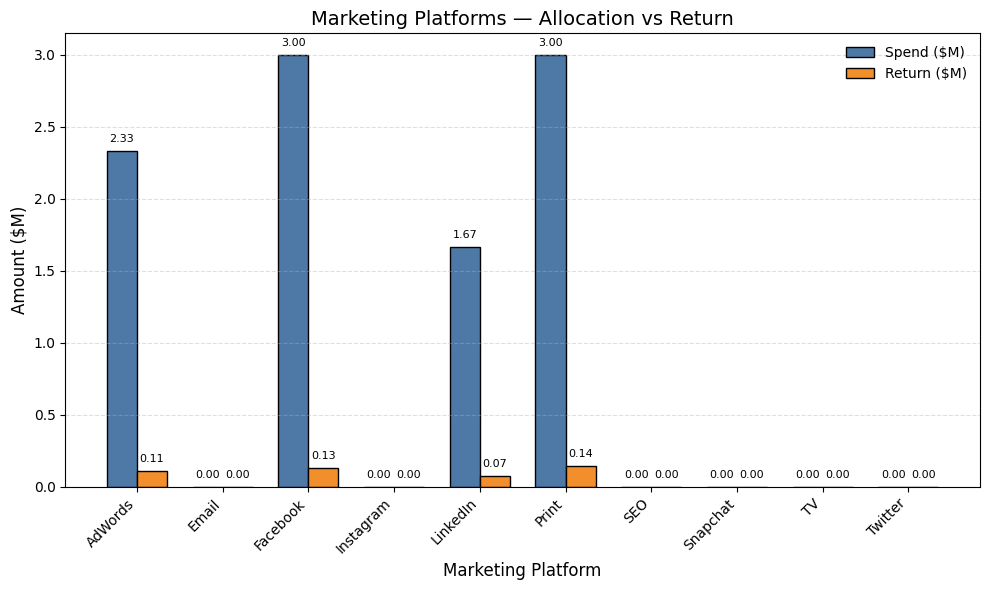

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- Create DataFrame from allocation results ---
alloc_df = pd.DataFrame(alloc, columns=["Platform", "Spend($M)", "Return($M)", "ROI"])
alloc_df.sort_values("Platform", inplace=True)

# --- X positions ---
x = np.arange(len(alloc_df["Platform"]))
bar_width = 0.35

fig, ax = plt.subplots(figsize=(10,6))

# --- Colors (Professional palette) ---
alloc_color = "#4E79A7"   # Deep steel blue for Spend
return_color = "#F28E2B"  # Warm amber orange for Return

# --- Plot bars ---
bars1 = ax.bar(x - bar_width/2, alloc_df["Spend($M)"], width=bar_width,
               color=alloc_color, edgecolor="black", label="Spend ($M)")
bars2 = ax.bar(x + bar_width/2, alloc_df["Return($M)"], width=bar_width,
               color=return_color, edgecolor="black", label="Return ($M)")

# --- Add data labels ---
for b in bars1:
    height = b.get_height()
    ax.text(b.get_x() + b.get_width()/2, height + 0.05, f"{height:.2f}",
            ha='center', va='bottom', fontsize=8, fontweight='medium')

for b in bars2:
    height = b.get_height()
    ax.text(b.get_x() + b.get_width()/2, height + 0.05, f"{height:.2f}",
            ha='center', va='bottom', fontsize=8, fontweight='medium')

# --- Formatting ---
ax.set_title("Marketing Platforms — Allocation vs Return", fontsize=14)
ax.set_xlabel("Marketing Platform", fontsize=12)
ax.set_ylabel("Amount ($M)", fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(alloc_df["Platform"], rotation=45, ha='right')
ax.grid(axis='y', linestyle='--', alpha=0.4)
ax.legend(frameon=False)
plt.tight_layout()
plt.show()


#### From the plot it can be noted that the 10 Million USD budget is optimally allocated across 4 marketing platforms namely Adwords, Facebook, LinkedIn and Print with 2.33 Million USD, 3 Million USD , 1.67 Million USD and 3 Million USD respectively.

#### The returns obtained by investing these amounts across these 4 platforms were 0.11 Million USD, 0.13 Million USD, 0.07 Million USD and 0.14 Million USD respectively.

### QN 7

Your boss has gained permission to reinvest half of the return. For example, if the marketing
obtains a 4% return in January, the budget of February will be $10M+ $10M × 4% × 50% =
$10.2M.  The monthly ROI for next year is given in the file “roi_monthly.csv”. The three
constraints given by your boss and the constraint for the minimum amounts are still in place for
each month. You do not need to implement the minimum amount constraint in Part 6). What is
the optimal allocation for each month?



In [ ]:
# q7_reinvest_monthly.py
import math
import pandas as pd
from gurobipy import Model, GRB, quicksum

# -----------------------------
# Config
# -----------------------------
BASE_BUDGET = 10.0      # $10M in Jan
PLATFORM_CAP = 3.0      # per-platform cap from boss
REINVEST_FRACTION = 0.5 # reinvest half of last month's return

# -----------------------------
# Load data
# -----------------------------
roiM = pd.read_csv("roi_monthly.csv")
mins = pd.read_csv("min_amount.csv")

# --- Validation checks ---
required_roi_cols = {"Month", "Platform", "Tier", "LowerBoundM", "UpperBoundM", "ROI"}
required_min_cols = {"Platform", "MinInvestment"}

if not required_roi_cols.issubset(set(roiM.columns)):
    missing = required_roi_cols - set(roiM.columns)
    raise ValueError(f"ERROR: roi_monthly.csv is missing required columns: {missing}")

if not required_min_cols.issubset(set(mins.columns)):
    missing = required_min_cols - set(mins.columns)
    raise ValueError(f"ERROR: min_amount.csv is missing required columns: {missing}")

print(f"✅ Loaded roi_monthly.csv with {len(roiM)} rows; columns = {list(roiM.columns)}")
print(f"✅ Loaded min_amount.csv with {len(mins)} rows; columns = {list(mins.columns)}\n")

# Normalize upper bounds (e.g., "inf")
def norm_ub(ub):
    if isinstance(ub, str) and ub.strip().lower() == "inf":
        return float("inf")
    return float(ub)

roiM["UpperBoundM"] = roiM["UpperBoundM"].apply(norm_ub)

# Month order (assume Jan..Dec present)
month_order = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
months_in_file = [m for m in month_order if m in roiM["Month"].unique().tolist()]
if not months_in_file:
    raise ValueError("No recognized months in roi_monthly.csv (expected names like Jan, Feb, ..., Dec).")

# Minimum amounts map
min_map = dict(zip(mins["Platform"], mins["MinInvestment"]))

# Social + boss constraint platform names
SOCIAL = ["Facebook", "LinkedIn", "Instagram", "Snapchat", "Twitter"]

# -----------------------------
# Helper: build & solve month MIP
# -----------------------------
def solve_month(month_name: str, budget_m: float, month_df: pd.DataFrame):
    """
    Solve a single-month MIP:
      - budget_m: available budget for this month
      - month_df: rows of roi_monthly for this month only
    Returns: (alloc_df, total_return)
    """
    # Compute effective tier capacity within [0, PLATFORM_CAP]
    def tier_len(lb, ub):
        ub_eff = min(ub, PLATFORM_CAP)
        if lb >= PLATFORM_CAP:
            return 0.0
        return max(0.0, ub_eff - lb)

    df = month_df.copy()
    df["TierCap"] = df.apply(lambda r: tier_len(float(r["LowerBoundM"]), float(r["UpperBoundM"])), axis=1)
    df = df[df["TierCap"] > 1e-9].copy()

    # Order tiers by lower bound per platform
    df.sort_values(["Platform", "LowerBoundM"], inplace=True)
    platforms = df["Platform"].unique().tolist()
    tiers_by_p = {p: df[df["Platform"] == p].reset_index(drop=True) for p in platforms}
    min_amt = {p: float(min_map.get(p, 0.0)) for p in platforms}

    # Build model
    m = Model(f"Q7_{month_name}")
    m.Params.OutputFlag = 0  # quiet; set 1 for debug

    # Variables
    y, z, w, x = {}, {}, {}, {}
    for p, dfp in tiers_by_p.items():
        w[p] = m.addVar(vtype=GRB.BINARY, name=f"w[{p}]")
        x[p] = m.addVar(lb=0.0, ub=PLATFORM_CAP, vtype=GRB.CONTINUOUS, name=f"x[{p}]")
        for idx, r in dfp.iterrows():
            y[p, idx] = m.addVar(lb=0.0, ub=float(r["TierCap"]), vtype=GRB.CONTINUOUS, name=f"y[{p},{idx}]")
            z[p, idx] = m.addVar(vtype=GRB.BINARY, name=f"z[{p},{idx}]")

    m.update()

    # Objective: maximize sum ROI * y
    m.setObjective(quicksum(
        tiers_by_p[p].loc[idx, "ROI"] * y[p, idx]
        for p in platforms for idx in range(len(tiers_by_p[p]))
    ), GRB.MAXIMIZE)

    # Constraints
    for p, dfp in tiers_by_p.items():
        # x_p definition
        m.addConstr(x[p] == quicksum(y[p, idx] for idx in range(len(dfp))), name=f"x_def[{p}]")
        # link to activation + min spend
        m.addConstr(x[p] <= PLATFORM_CAP * w[p], name=f"cap_link[{p}]")
        m.addConstr(x[p] >= min_amt[p] * w[p], name=f"min_link[{p}]")
        # tier capacity + precedence (fill earlier tiers before later ones)
        for idx, r in dfp.iterrows():
            m.addConstr(y[p, idx] <= float(r["TierCap"]) * z[p, idx], name=f"cap[{p},{idx}]")
            if idx >= 1:
                prev_cap = float(dfp.loc[idx-1, "TierCap"])
                m.addConstr(y[p, idx-1] >= prev_cap * z[p, idx], name=f"precede[{p},{idx}]")

    # Budget
    m.addConstr(quicksum(x[p] for p in platforms) == budget_m, name="budget")

    # Boss constraints
    # (a) Print + TV <= Facebook + Email
    if "Print" in x and "TV" in x and "Facebook" in x and "Email" in x:
        m.addConstr(x["Print"] + x["TV"] <= x["Facebook"] + x["Email"], name="boss_a")
    else:
        # If any of these platforms are missing in this month (shouldn't happen under spec), skip a)
        pass

    # (b) Social >= 2 * (SEO + AdWords)
    # Only sum those that exist in this month set
    social_vars = [x[p] for p in SOCIAL if p in x]
    seo_var = x["SEO"] if "SEO" in x else None
    adw_var = x["AdWords"] if "AdWords" in x else None
    if social_vars and (seo_var is not None) and (adw_var is not None):
        m.addConstr(quicksum(social_vars) >= 2.0 * (seo_var + adw_var), name="boss_b")

    # (c) Each platform <= PLATFORM_CAP (already in var upper bounds and cap_link)

    m.optimize()

    if m.status not in [GRB.OPTIMAL, GRB.TIME_LIMIT, GRB.SUBOPTIMAL]:
        raise RuntimeError(f"Month {month_name} optimization failed with status {m.status}")

    # Collect results
    records = []
    total_return = 0.0
    for p in sorted(platforms):
        spend = x[p].X
        ret = sum(tiers_by_p[p].loc[idx, "ROI"] * y[p, idx].X for idx in range(len(tiers_by_p[p])))
        total_return += ret
        roi_val = (ret / spend) if spend > 1e-9 else 0.0
        records.append({"Month": month_name, "Platform": p,
                        "Spend($M)": round(spend, 6),
                        "Return($M)": round(ret, 6),
                        "ROI(Return/Spend)": round(roi_val, 6)})
    alloc_df = pd.DataFrame(records).sort_values(["Month","Platform"])
    return alloc_df, total_return

# -----------------------------
# Solve months sequentially
# -----------------------------
all_allocs = []
budget = BASE_BUDGET

for mname in months_in_file:
    mdf = roiM[roiM["Month"] == mname].copy()
    print(f"--- Solving {mname}: Budget = ${budget:.4f}M ---")
    alloc_df, ret_m = solve_month(mname, budget, mdf)
    all_allocs.append(alloc_df)
    print(f"{mname} total return = ${ret_m:.4f}M")
    budget = budget + REINVEST_FRACTION * ret_m  # reinvest half of this month's return
    print(f"Next month budget will be = ${budget:.4f}M\n")

final_df = pd.concat(all_allocs, ignore_index=True)

# Pretty print per month summary
print("\n=== Monthly Allocation Summary ===")
for mname in months_in_file:
    dfm = final_df[final_df["Month"] == mname]
    print(f"\n{mname}:")
    print(dfm[["Platform","Spend($M)","Return($M)","ROI(Return/Spend)"]]
          .sort_values("Platform").to_string(index=False))


✅ Loaded roi_monthly.csv with 362 rows; columns = ['Month', 'Platform', 'Tier', 'LowerBoundM', 'UpperBoundM', 'ROI']
✅ Loaded min_amount.csv with 10 rows; columns = ['Platform', 'MinInvestment']

--- Solving Jan: Budget = $10.0000M ---
Jan total return = $0.5394M
Next month budget will be = $10.2697M

--- Solving Feb: Budget = $10.2697M ---
Feb total return = $0.4207M
Next month budget will be = $10.4801M

--- Solving Mar: Budget = $10.4801M ---
Mar total return = $0.5488M
Next month budget will be = $10.7545M

--- Solving Apr: Budget = $10.7545M ---
Apr total return = $0.5237M
Next month budget will be = $11.0163M

--- Solving May: Budget = $11.0163M ---
May total return = $0.6315M
Next month budget will be = $11.3321M

--- Solving Jun: Budget = $11.3321M ---
Jun total return = $0.5305M
Next month budget will be = $11.5973M

--- Solving Jul: Budget = $11.5973M ---
Jul total return = $0.6114M
Next month budget will be = $11.9030M

--- Solving Aug: Budget = $11.9030M ---
Aug total retur

In [ ]:
# --- Pivoted Monthly Summary Table ---
import pandas as pd

# Summarize total return per month
total_return_per_month = (
    final_df.groupby("Month")["Return($M)"].sum().rename("Total Return (M$)")
)

# Pivot to have Platforms as columns, Months as rows
pivot_alloc = (
    final_df.pivot_table(
        index="Month",
        columns="Platform",
        values="Spend($M)",
        aggfunc="sum",
        fill_value=0,
    )
    .join(total_return_per_month, how="left")
)

# Ensure months are in chronological order
month_order = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
pivot_alloc = pivot_alloc.reindex(month_order)

# Display neatly
print("\n--- Pivoted Monthly Budget Allocation (Chronological Order) ---")
print(pivot_alloc.round(4).to_string())



--- Pivoted Monthly Budget Allocation (Chronological Order) ---
       AdWords   Email  Facebook  Instagram  LinkedIn   Print  SEO  Snapchat   TV  Twitter  Total Return (M$)
Month                                                                                                        
Jan     0.0000  0.0000     3.000     0.0000       3.0  3.0000  0.0     0.000  0.0   1.0000             0.5394
Feb     2.5500  0.0000     3.000     0.0000       2.1  2.6197  0.0     0.000  0.0   0.0000             0.4207
Mar     2.6960  0.0000     2.392     0.0000       3.0  2.3920  0.0     0.000  0.0   0.0000             0.5488
Apr     1.7545  0.0000     3.000     0.0000       3.0  3.0000  0.0     0.000  0.0   0.0000             0.5237
May     0.0000  3.0000     0.000     2.0163       3.0  3.0000  0.0     0.000  0.0   0.0000             0.6315
Jun     0.0000  0.0000     3.000     0.0000       3.0  3.0000  0.0     0.000  0.0   2.3321             0.5305
Jul     0.0000  0.0000     3.000     0.0000       3.0  

#### This Pivoted Table Structure depicts the monthly allocation of the Marketing Budget across each of the 10 marketing platforms along with the total return obtained from each month

#### Visuals

/tmp/ipython-input-3009761878.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  i, total_allocation[i] + 0.1,   # small offset above marker
/tmp/ipython-input-3009761878.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f"{total_allocation[i]:.2f}",
/tmp/ipython-input-3009761878.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  i, total_return[i] - 0.2,       # small offset below marker
/tmp/ipython-input-3009761878.py:42: 

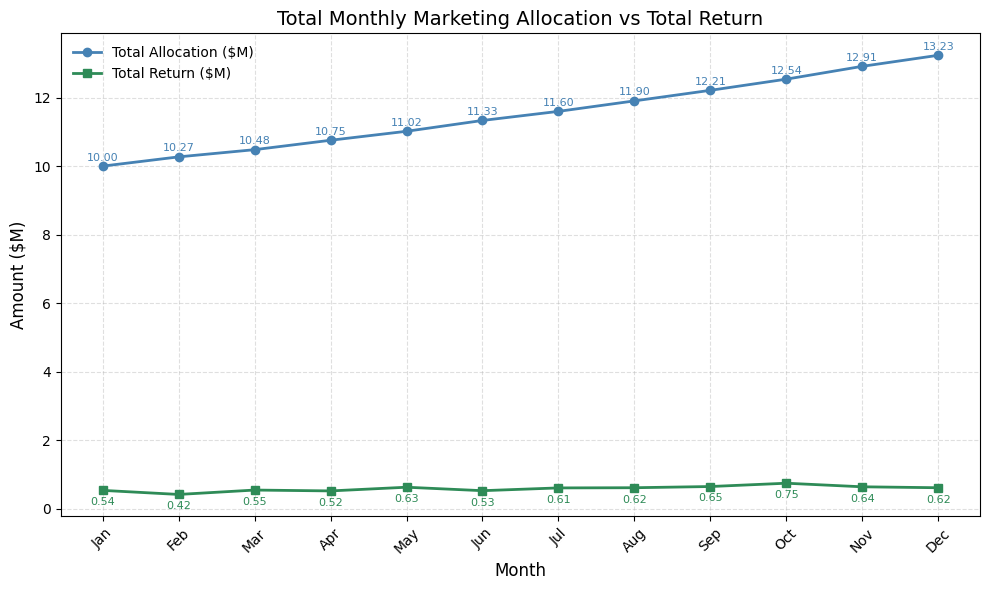

In [ ]:
import matplotlib.pyplot as plt

# --- Calculate total allocation per month ---
total_allocation = pivot_alloc.drop(columns=["Total Return (M$)"]).sum(axis=1)
total_return = pivot_alloc["Total Return (M$)"]

# --- Create line plot ---
plt.figure(figsize=(10,6))

# Plot total allocation (blue line)
plt.plot(
    pivot_alloc.index,
    total_allocation,
    color='steelblue',
    marker='o',
    linewidth=2,
    label='Total Allocation ($M)'
)

# Plot total return (green line)
plt.plot(
    pivot_alloc.index,
    total_return,
    color='seagreen',
    marker='s',
    linewidth=2,
    label='Total Return ($M)'
)

# --- Add data labels for each point ---
for i, month in enumerate(pivot_alloc.index):
    # Label for total allocation
    plt.text(
        i, total_allocation[i] + 0.1,   # small offset above marker
        f"{total_allocation[i]:.2f}",
        ha='center', va='bottom',
        fontsize=8, color='steelblue', fontweight='medium'
    )
    # Label for total return
    plt.text(
        i, total_return[i] - 0.2,       # small offset below marker
        f"{total_return[i]:.2f}",
        ha='center', va='top',
        fontsize=8, color='seagreen', fontweight='medium'
    )

# --- Titles and labels ---
plt.title("Total Monthly Marketing Allocation vs Total Return", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Amount ($M)", fontsize=12)
plt.grid(alpha=0.4, linestyle='--')
plt.xticks(rotation=45)
plt.legend(loc='upper left', frameon=False)
plt.tight_layout()
plt.show()

#### From the above lineplot, while the marketing budget inreases as we go from January to December since the 50% of returns are reinvested into the next month from the previous month, the total returns obtained from each month however isn't necessarily increasing as we go from January to December.

#### February had the lowest return of 0.42 Million USD whereas October had the highest return of 0.75 Million USD.

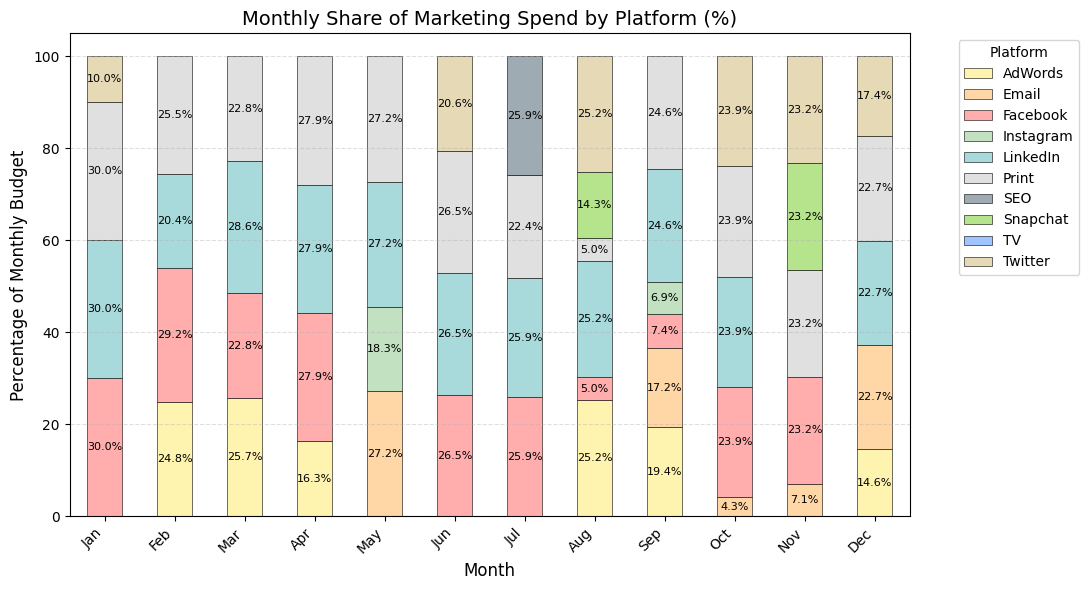

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- Define platform columns (exclude total return) ---
platform_cols = [c for c in pivot_alloc.columns if c != "Total Return (M$)"]

# --- Compute monthly percentage share per platform ---
spend_pct = pivot_alloc[platform_cols].div(
    pivot_alloc[platform_cols].sum(axis=1), axis=0
) * 100

# --- Refined Light Muted Professional Palette ---
custom_colors = [
    "#FFF3B0",  # Light Yellow
    "#FFD6A5",  # Light Orange
    "#FFADAD",  # Light Coral Red
    "#C1E1C1",  # Pale Mint Teal
    "#A8DADC",  # Soft Sky Blue
    "#E0E0E0",  # Light Warm Grey
    "#9EABB3",  # Cool Slate Grey (better contrast)
    "#B5E48C",  # Pastel Green
    "#A0C4FF",  # Light Aqua Blue
    "#E5D9B6"   # Light Sand
][:len(platform_cols)]

# --- Plot stacked percentage bar chart ---
ax = spend_pct.plot(
    kind='bar',
    stacked=True,
    figsize=(11,6),
    color=custom_colors,
    edgecolor='black',
    linewidth=0.4
)

# --- Add percentage labels to each segment ---
for idx, month in enumerate(spend_pct.index):
    cumulative = 0
    for p in platform_cols:
        val = spend_pct.loc[month, p]
        if val > 3:  # Label only significant segments
            plt.text(
                idx,
                cumulative + val / 2,
                f"{val:.1f}%",
                ha='center',
                va='center',
                fontsize=8,
                color='black',
                weight='medium'
            )
        cumulative += val

# --- Titles and formatting ---
plt.title("Monthly Share of Marketing Spend by Platform (%)", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Percentage of Monthly Budget", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.legend(title="Platform", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


#### This Stacked Bar Chart depicts the composition of marketing budget spend across the 10 markting platforms from January to December.

#### It should be noted that the marketing budget increases monthly as we go from January to December. However, some patterns can be observed here.

#### LinkedIn dominates the monthly allocation spends (except for Feb) across the months whenever it is considered for investment.

#### There is a monthly allocation into the Print Platform for all the 12 months

#### SEO is preferred only in July for investment

#### Aug and Sep are the only months were the budget is spend across a maximum of 6 marketing platforms.


### QN 8 Stability Assessment and also (are the returns are reinvested into the budget for next month ?)

A stable budget is defined as a monthly allocation such that for each platform the monthly
change in spend is no more than $1M. Is the allocation you found stable? If it isn’t, you do not
need to solve a new optimization model.  Describe how you might model this?

In [ ]:
# --- Stability check (Q8) ---
print("\n--- Stability Check (Q8) ---")

# Extract only platform columns (exclude 'Total Return (M$)')
platform_cols = [c for c in pivot_alloc.columns if c != "Total Return (M$)"]

# Compute month-over-month differences
diffs = pivot_alloc[platform_cols].diff().abs().fillna(0)

# Identify violations > $1M
violations = diffs > 1.0

# Summarize stability
if not violations.values.any():
    print("✅ The allocation is stable: all monthly changes are within $1M for each platform.")
else:
    print("⚠️ The allocation is NOT stable. Some platforms exceed $1M change between months.\n")
    print("Details (changes > $1M):")
    unstable = diffs[violations]
    print(unstable.dropna(how='all').round(3).to_string())



--- Stability Check (Q8) ---
⚠️ The allocation is NOT stable. Some platforms exceed $1M change between months.

Details (changes > $1M):
       AdWords  Email  Facebook  Instagram  LinkedIn  Print  SEO  Snapchat  TV  Twitter
Month                                                                                  
Feb      2.550    NaN       NaN        NaN       NaN    NaN  NaN       NaN NaN      NaN
May      1.754  3.000       3.0      2.016       NaN    NaN  NaN       NaN NaN      NaN
Jun        NaN  3.000       3.0      2.016       NaN    NaN  NaN       NaN NaN    2.332
Jul        NaN    NaN       NaN        NaN       NaN    NaN  3.0       NaN NaN    2.332
Aug      3.000    NaN       2.4        NaN       NaN  1.997  3.0     1.703 NaN    3.000
Sep        NaN  2.100       NaN        NaN       NaN  2.400  NaN     1.703 NaN    3.000
Oct      2.370  1.563       2.1        NaN       NaN    NaN  NaN       NaN NaN    3.000
Nov        NaN    NaN       NaN        NaN       3.0    NaN  NaN     3

#### This Output depicts the change in marketing spends across the 10 marketing platforms for each of the months from February to December.

#### The values are shown where the stability criteria (change in monthly allocation of marketing spend for each platform > 1 Million USD) has been violated. It is NaN otherwise.

#### The stability criteria has been violated the most in August and the least in February.

In [ ]:
# --- Detailed Stability Violations Summary (Q8 Extended) ---
print("\n--- Stability Violations Summary ---")

# Extract platform columns (exclude total return)
platform_cols = [c for c in pivot_alloc.columns if c != "Total Return (M$)"]
months = pivot_alloc.index.tolist()

violations_list = []

for i in range(1, len(months)):
    prev_month = months[i - 1]
    curr_month = months[i]
    for p in platform_cols:
        prev_val = pivot_alloc.loc[prev_month, p]
        curr_val = pivot_alloc.loc[curr_month, p]
        change = abs(curr_val - prev_val)
        if change > 1.0:  # violation threshold
            violations_list.append({
                "Platform": p,
                "Month From": prev_month,
                "Month To": curr_month,
                "Spend Change (M$)": round(change, 4),
                "Previous Spend (M$)": round(prev_val, 4),
                "Current Spend (M$)": round(curr_val, 4)
            })

# Convert to DataFrame
viol_df = pd.DataFrame(violations_list)

if viol_df.empty:
    print("✅ The allocation is stable — no changes exceed $1M between months.")
else:
    print(viol_df.to_string(index=False))
    print(f"\n⚠️ Total Violations: {len(viol_df)} (i.e., number of platform-month transitions exceeding $1M)\n")


--- Stability Violations Summary ---
 Platform Month From Month To  Spend Change (M$)  Previous Spend (M$)  Current Spend (M$)
  AdWords        Jan      Feb             2.5500               0.0000              2.5500
  AdWords        Apr      May             1.7545               1.7545              0.0000
    Email        Apr      May             3.0000               0.0000              3.0000
 Facebook        Apr      May             3.0000               3.0000              0.0000
Instagram        Apr      May             2.0163               0.0000              2.0163
    Email        May      Jun             3.0000               3.0000              0.0000
 Facebook        May      Jun             3.0000               0.0000              3.0000
Instagram        May      Jun             2.0163               2.0163              0.0000
  Twitter        May      Jun             2.3321               0.0000              2.3321
      SEO        Jun      Jul             3.0000              

####This output records the times the stability criteria have been violated for each of the marketing platforms.

### Enforcing Stability

To enforce stability for the monthly allocations for each of the marketing platforms, we can add two stability constraints that can help achieve this.

The stability constraints can be written as:

$$
x_{p,t} - x_{p,t-1} \le 1 \\
x_{p,t-1} - x_{p,t} \le 1
$$

where $x_{p,t}$ is the monthly spend (in \$M) on platform $p$ in month $t$.


## Visualizations

#### Which marketing platform had the maximum violations?

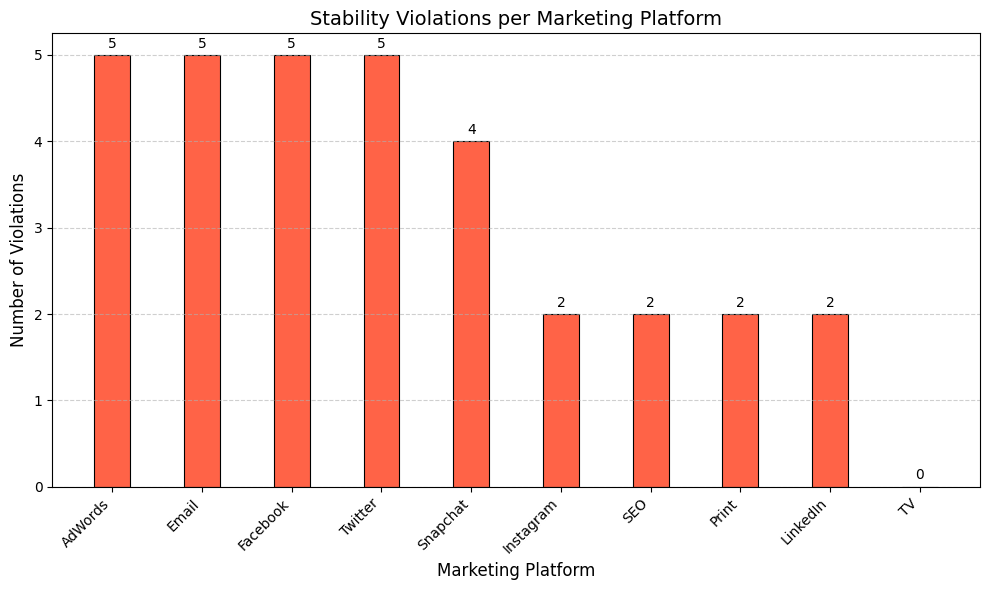

In [ ]:
# --- Bar Chart: Count of Stability Violations per Platform (Styled, Includes Zero Violations) ---
import matplotlib.pyplot as plt
import pandas as pd

if 'pivot_alloc' in globals():
    # All platforms (excluding total return)
    all_platforms = [c for c in pivot_alloc.columns if c != "Total Return (M$)"]

    # Count violations per platform
    if not viol_df.empty:
        violation_counts = viol_df["Platform"].value_counts()
    else:
        violation_counts = pd.Series(dtype=int)

    # Ensure all platforms are present (fill missing with 0)
    for p in all_platforms:
        if p not in violation_counts:
            violation_counts[p] = 0

    # Sort in descending order
    violation_counts = violation_counts.sort_values(ascending=False)

    # --- Plot ---
    plt.figure(figsize=(10, 6))
    bar_width = 0.4

    plt.bar(
        violation_counts.index,
        violation_counts.values,
        width=bar_width,
        color='tomato',
        edgecolor='black',
        linewidth=0.8
    )

    # Title and labels
    plt.title("Stability Violations per Marketing Platform", fontsize=14)
    plt.xlabel("Marketing Platform", fontsize=12)
    plt.ylabel("Number of Violations", fontsize=12)

    # Add text labels above bars
    for i, v in enumerate(violation_counts.values):
        plt.text(i, v + 0.05, str(int(v)), ha='center', va='bottom', fontsize=10, fontweight='medium')

    # Aesthetic tweaks
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

else:
    print("⚠️ 'pivot_alloc' not found. Please run the earlier steps (Question 7 & 8) first.")

####From the bar chart, it can be noted that 4 platforms (AdWords, Email, Facebook, Twitter)have maximum number of violations at 5 each, then followed by Snapchat at 4, then 4 platforms ( Instagram, SEO, Print, LinkedIn) have 2 violations each and TV is the only platform with no stability violations.

####This visual gives the trend of allocations across each of the marketing platforms

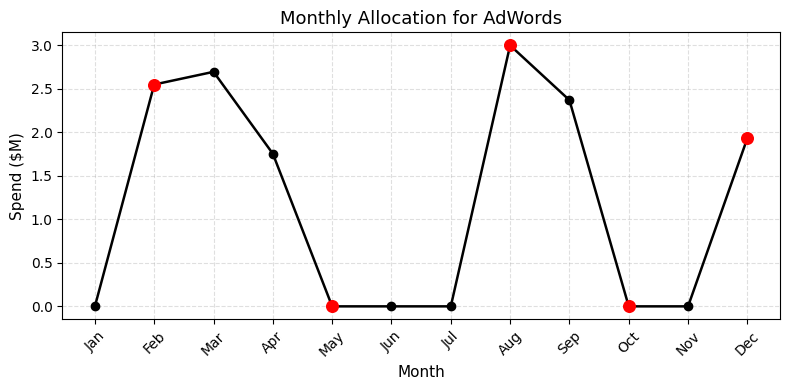

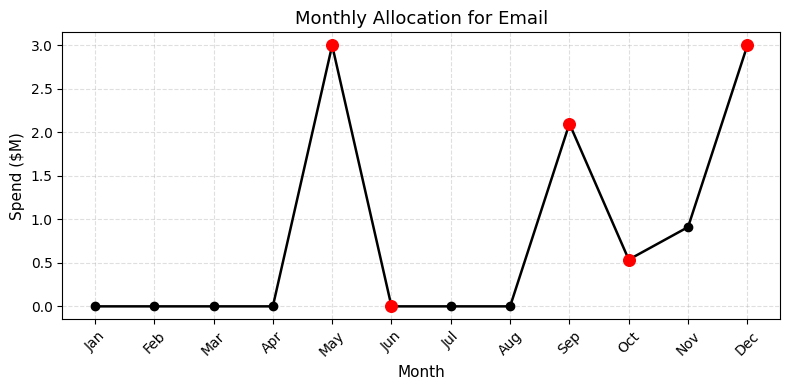

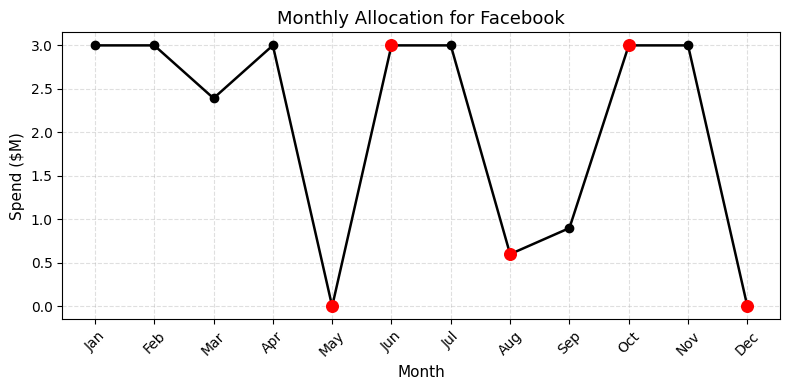

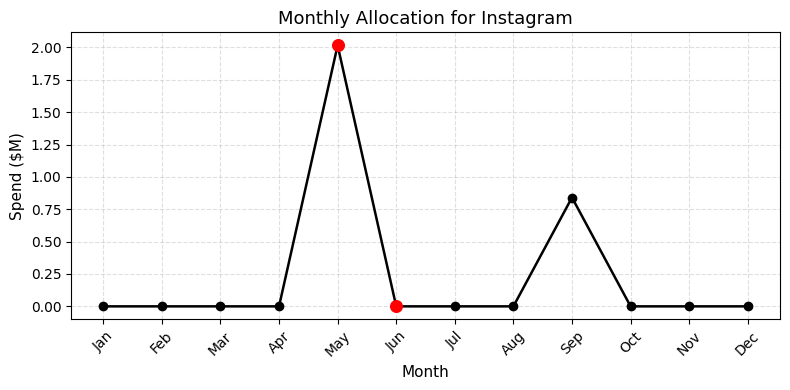

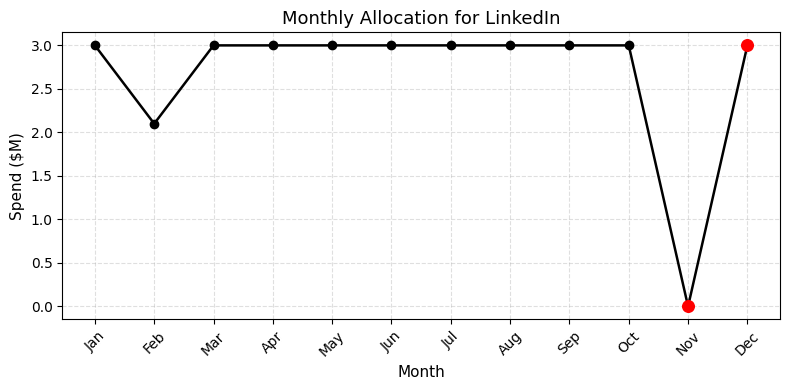

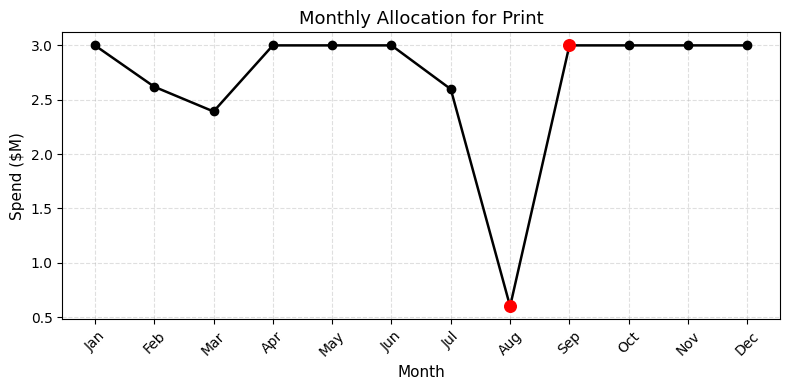

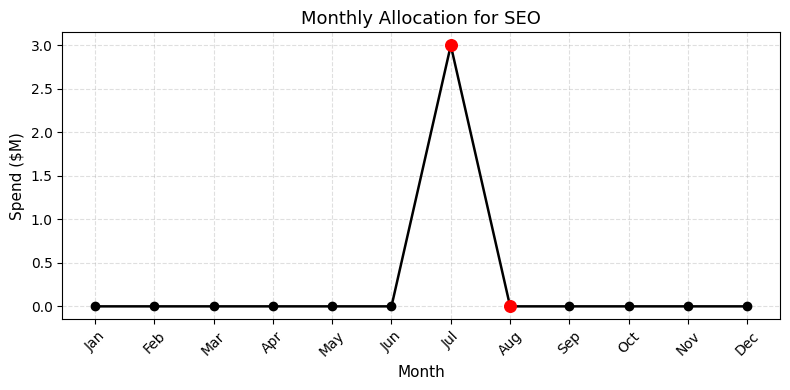

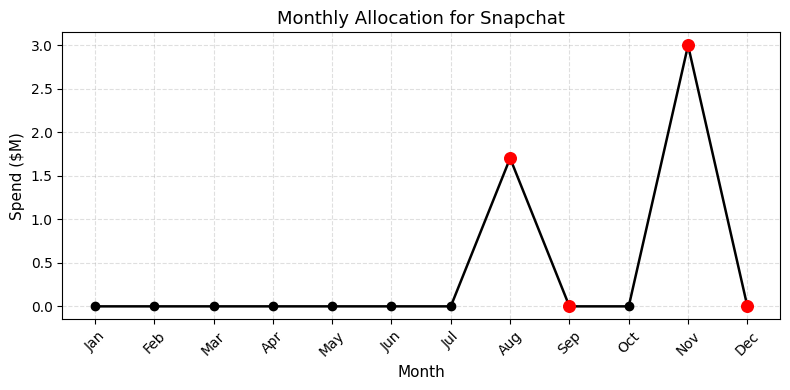

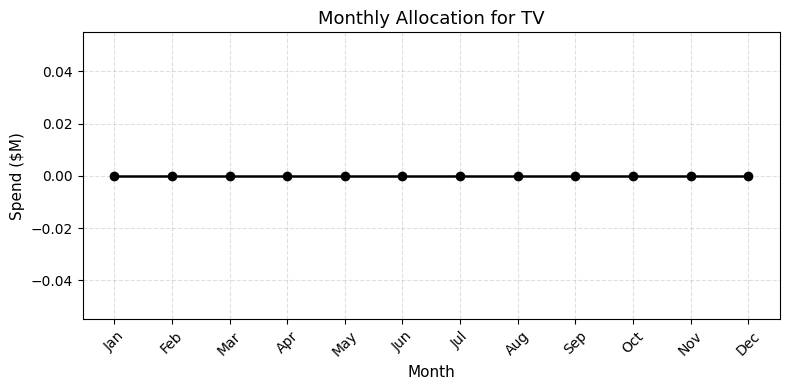

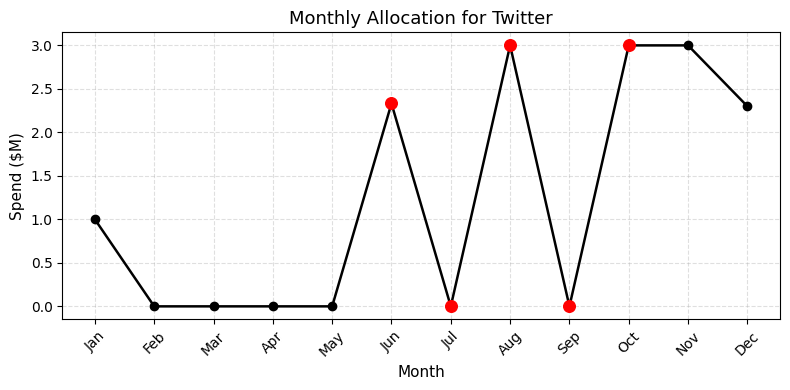

In [ ]:
# --- Separate Line Plots for Each Platform Highlighting Stability Violations ---
import matplotlib.pyplot as plt

if not pivot_alloc.empty:
    # Get platform columns (exclude total return)
    platform_cols = [c for c in pivot_alloc.columns if c != "Total Return (M$)"]
    months = pivot_alloc.index.tolist()
    month_idx = range(len(months))

    for p in platform_cols:
        plt.figure(figsize=(8, 4))

        # Extract the monthly spend values for this platform
        y_vals = pivot_alloc.loc[:, p].values

        # Plot the black line for all months
        plt.plot(month_idx, y_vals, color='black', linewidth=1.8, marker='o')

        # Identify months where stability was violated for this platform
        if 'viol_df' in globals() and not viol_df.empty:
            viol_months = viol_df.loc[viol_df["Platform"] == p, "Month To"].tolist()
            viol_indices = [months.index(m) for m in viol_months if m in months]
            viol_points = [y_vals[i] for i in viol_indices]

            # Red markers for violations
            plt.scatter(viol_indices, viol_points, color='red', s=70, zorder=3, label="Violation (> $1M change)")

        # Formatting
        plt.title(f"Monthly Allocation for {p}", fontsize=13)
        plt.xlabel("Month", fontsize=11)
        plt.ylabel("Spend ($M)", fontsize=11)
        plt.xticks(month_idx, months, rotation=45)
        plt.grid(alpha=0.4, linestyle='--')
        plt.tight_layout()



        plt.show()

else:
    print("⚠️ pivot_alloc not found or empty. Please run Question 7 & 8 steps first.")

#### From these plots,

####It can be observed that for Twitter, the stability criteria violation occurs continuously from June to October.

#### TV is the most stable platform with zero stability violations.
